In [1]:
# 04-preprocessing-training.ipynb

# Author: Błażej Białczak
# Date: May 2025
# Description: Preprocessing and training

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns


## Pipeline

### Preprocessing

PCA Visualization

In [33]:
data_path = 'Torgo_selected.csv'

In [34]:
torgo = pd.read_csv(data_path)

torgo_2 = torgo.copy()
y = torgo['label']
X = torgo.drop('label', axis=1)

In [35]:
torgo.isna().sum().sum()

np.int64(0)

In [36]:
# scaler = StandardScaler()
scaler = QuantileTransformer(output_distribution='normal')
X = scaler.fit_transform(X)

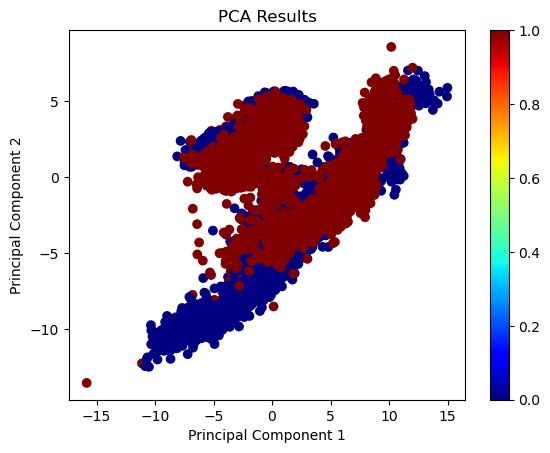

In [37]:
pca = PCA(n_components = 2, random_state=42)
X_pca = X.copy()
X_pca  = pca.fit_transform(X_pca)

plt.scatter(X_pca[: , 0], X_pca[: , 1], c=y.astype(int), cmap="jet")
plt.title("PCA Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

t-SNE Visualization

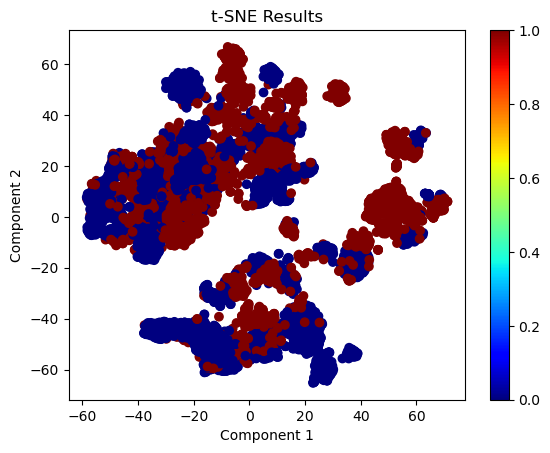

In [38]:
tsne = TSNE(n_components = 2, random_state=42, perplexity=100)
X_tsne = X.copy()
X_tsne = tsne.fit_transform(X_tsne)

plt.scatter(X_tsne[: , 0], X_tsne[: , 1], c=y.astype(int), cmap="jet")
plt.title("t-SNE Results")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar()
plt.show()

Decide number of relevant components to 95% of relevant information

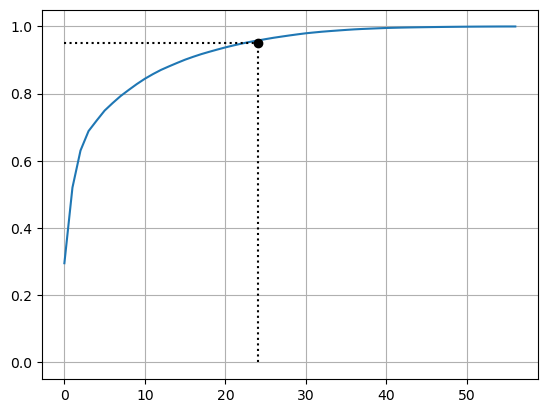

In [39]:
pca = PCA(random_state=42)

X_train_pca  = X.copy()
X_train_pca = pca.fit_transform(X_train_pca)
cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components_pca = np.argmax(cumsum >= 0.95) + 1

plt.plot(cumsum)
plt.plot([n_components_pca, n_components_pca], [0, 0.95], "k:")
plt.plot([0, n_components_pca], [0.95, 0.95], "k:")
plt.plot(n_components_pca, 0.95, "ko")
plt.grid()
plt.show()

Pipeline

In [40]:
pca = PCA(n_components=n_components_pca, random_state=42)
tsne = TSNE(n_components= 2 , random_state=42)

pca_pipeline = Pipeline([
    ('scaler', QuantileTransformer(output_distribution='normal')) ,
    ('pca', pca),
])
tsne_pipeline = Pipeline([{
    'scaler', RobustScaler(),
    'tsne', tsne
}])


## Training

In [41]:
Y = torgo['label']
X = torgo.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42, n_jobs=-1)

model_pipeline = Pipeline ([
    ('preprocessing', pca_pipeline),
    ('forest', clf),
])

In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

param_grid = {
    'forest__n_estimators': [500, 700, 1000],
    'forest__max_depth': [40, 50, 60],
    'forest__max_features': ['sqrt', 'log2', None],
}

rnd_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=3,
    scoring='recall_macro',
    n_jobs=-1
)

rnd_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('scaler',
                                                         QuantileTransformer(output_distribution='normal')),
                                                        ('pca',
                                                         PCA(n_components=np.int64(24),
                                                             random_state=42))])),
                                       ('forest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'forest__max_depth': [40, 50, 60],
                         'forest__max_features': ['sqrt', 'log2', None],
                         'forest__n_estimators': [500, 700, 1000]},
             scoring='recall_macro')

In [44]:
model = rnd_search.best_estimator_
rnd_search.best_params_

{'forest__max_depth': 40,
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 700}

In [45]:
best_params = rnd_search.best_params_

In [46]:
cv_df = pd.DataFrame(rnd_search.cv_results_)
cv_df = cv_df.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)
cv_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_df.head(5)


,param_forest__max_depth,param_forest__max_features,param_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,40,sqrt,700,"{'forest__max_depth': 40, 'forest__max_feature...",0.910883,0.915388,0.908089,0.911454,0.003007,1
10,50,sqrt,700,"{'forest__max_depth': 50, 'forest__max_feature...",0.910883,0.915388,0.908089,0.911454,0.003007,1
4,40,log2,700,"{'forest__max_depth': 40, 'forest__max_feature...",0.910883,0.915388,0.908089,0.911454,0.003007,1
19,60,sqrt,700,"{'forest__max_depth': 60, 'forest__max_feature...",0.910883,0.915388,0.908089,0.911454,0.003007,1
22,60,log2,700,"{'forest__max_depth': 60, 'forest__max_feature...",0.910883,0.915388,0.908089,0.911454,0.003007,1


In [47]:
joblib.dump(rnd_search.best_params_, 'best_params.pkl')

['best_params.pkl']

In [48]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Visualization

In [49]:
# StandardScaler
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2066
           1       0.97      0.86      0.91      1009

    accuracy                           0.95      3075
   macro avg       0.95      0.92      0.94      3075
weighted avg       0.95      0.95      0.94      3075

Accuracy:  0.9453658536585365
Recall:  0.9228338947536068
Precision:  0.9535648162918335
F1 Score:  0.9359874780305456


<Axes: >

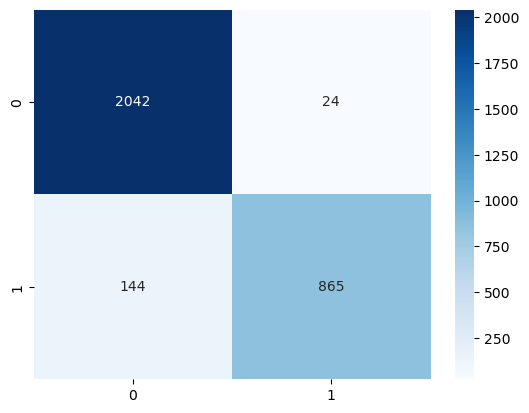

In [50]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')

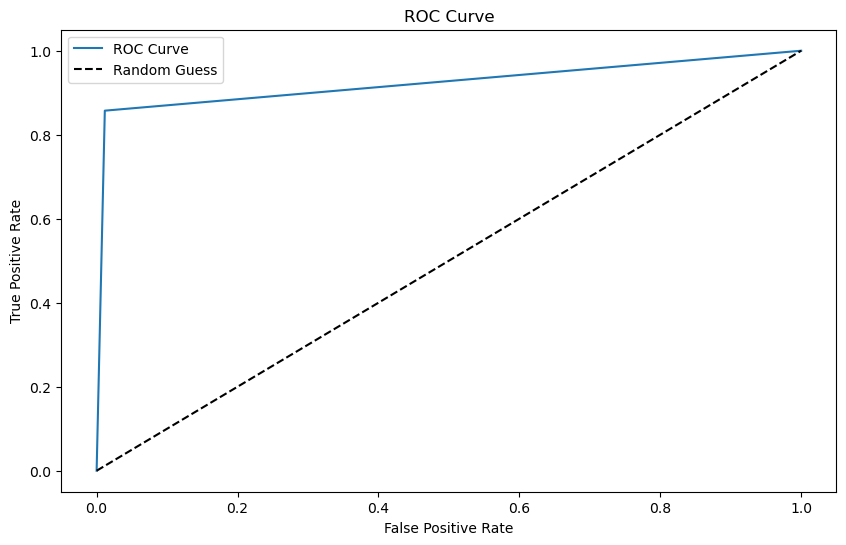

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()


### Plotting one of the trees

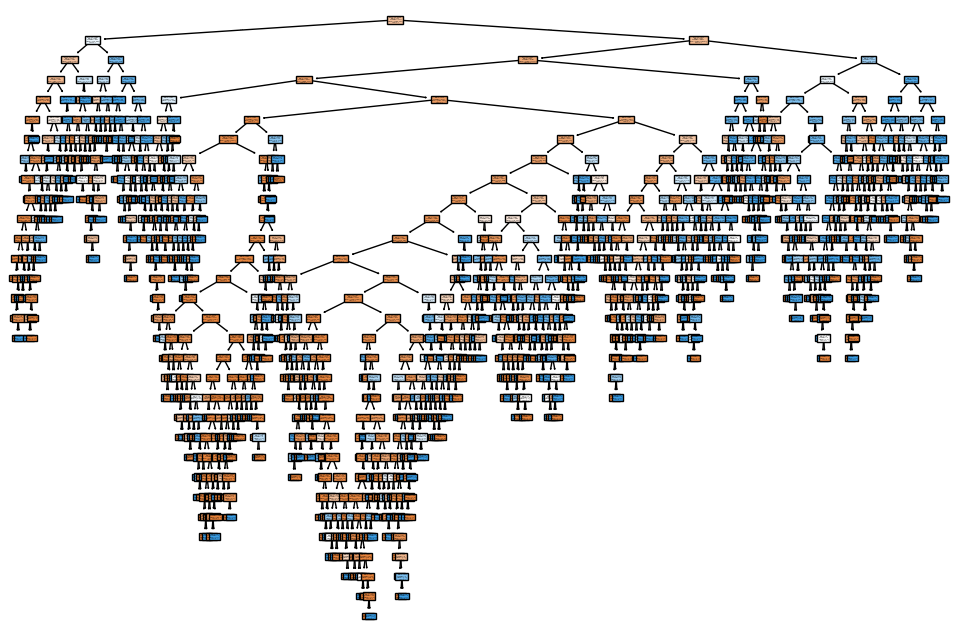

In [52]:
from sklearn.tree import plot_tree

tree_clf = model.named_steps['forest'][0]

plt.figure(figsize=(12, 8))
plot_tree(tree_clf,  feature_names=model.named_steps['preprocessing'].named_steps['pca'].get_feature_names_out(), class_names=[str(cls) for cls in y_train.unique()], filled=True)
plt.show()

In [53]:
joblib.dump(model, 'best_model.pkl')

['best_model.pkl']

## Training using short-word and non-words

In [54]:
short_words = pd.read_csv('Torgo_selected_group1.csv')
long_words = pd.read_csv('Torgo_selected_group2.csv')


In [55]:
short_words.head()

,label,0,1,2,3,4,5,6,7,8,...,45,46,47,48,49,50,51,52,53,54
0,0,0.184410,1.273322,0.220922,0.015476,0.016008,0.016315,0.017720,0.018235,0.020389,...,-3.462362,-16.111482,-7.778514,-10.919192,-4.185398,1.887481,-11.467344,-7.579661,-1.545831,-4.981239
1,0,0.277446,1.213796,0.239385,0.010860,0.011123,0.011627,0.012759,0.013130,0.014228,...,0.458492,-18.029919,-7.755306,-11.975713,-5.653173,2.960525,-11.595507,-7.003992,-1.133004,-4.651984
2,0,-1.541566,1.361026,0.282031,0.008565,0.013251,0.014728,0.019190,0.019788,0.022978,...,-1.448715,-12.068555,-6.343857,-11.931686,-3.549286,3.298603,-12.613104,-8.174975,-1.733258,-5.088470
3,0,1.654178,1.245388,0.075248,0.023994,0.024223,0.024578,0.026035,0.026953,0.029474,...,3.279393,-5.111146,-1.878599,1.480944,-4.954466,2.208425,-8.516620,-9.873207,-2.680927,-5.904635
4,0,1.860655,1.245030,0.086818,0.025851,0.025442,0.025380,0.026406,0.027410,0.029056,...,2.588958,-3.643089,-1.235433,2.168651,-8.106110,2.626825,-5.775693,-9.704240,-2.168878,-4.247734


In [56]:
long_words.head()

,label,0,1,2,3,4,5,6,7,8,...,42,43,44,45,46,47,48,49,50,51
0,0,0.540404,3.008636,0.190477,0.032295,0.050011,0.057960,0.064294,0.071564,0.065637,...,-11.659213,-9.763777,-2.199593,0.731851,2.687152,-10.489539,-6.580446,-9.574183,-1.328710,-2.098385
1,0,0.290942,2.734711,0.225196,0.031464,0.048522,0.062931,0.070003,0.075401,0.068282,...,-8.720408,-12.324286,-1.953413,-2.142450,2.626502,-9.394972,-5.986003,-11.849911,-1.549451,-0.787103
2,0,1.039691,1.988635,0.135301,0.037257,0.050971,0.058004,0.066791,0.070776,0.063427,...,-9.980419,-10.700445,-1.657135,-3.011083,3.088891,-8.179048,-8.116875,-10.110847,2.367876,-4.684633
3,0,0.756902,2.090971,0.150670,0.029686,0.046963,0.059100,0.066760,0.072753,0.067089,...,-13.267417,-10.286315,-2.131489,-2.447496,3.166144,-10.229048,-6.461072,-10.193707,-0.790113,-2.852926
4,0,1.040273,1.954819,0.121780,0.030670,0.049172,0.060147,0.067751,0.074155,0.067258,...,-13.175241,-8.165514,-3.662318,-2.548866,1.958989,-11.311574,-6.719166,-9.075631,1.884249,-2.546962


In [57]:
short_words.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10748 entries, 0 to 10747
Data columns (total 56 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   10748 non-null  int64  
 1   0       10748 non-null  float64
 2   1       10748 non-null  float64
 3   2       10748 non-null  float64
 4   3       10748 non-null  float64
 5   4       10748 non-null  float64
 6   5       10748 non-null  float64
 7   6       10748 non-null  float64
 8   7       10748 non-null  float64
 9   8       10748 non-null  float64
 10  9       10748 non-null  float64
 11  10      10748 non-null  float64
 12  11      10748 non-null  float64
 13  12      10748 non-null  float64
 14  13      10748 non-null  float64
 15  14      10748 non-null  float64
 16  15      10748 non-null  float64
 17  16      10748 non-null  float64
 18  17      10748 non-null  float64
 19  18      10748 non-null  float64
 20  19      10748 non-null  float64
 21  20      10748 non-null  float64
 22

In [58]:
long_words.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3768 entries, 0 to 3767
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   3768 non-null   int64  
 1   0       3768 non-null   float64
 2   1       3768 non-null   float64
 3   2       3768 non-null   float64
 4   3       3768 non-null   float64
 5   4       3768 non-null   float64
 6   5       3768 non-null   float64
 7   6       3768 non-null   float64
 8   7       3768 non-null   float64
 9   8       3768 non-null   float64
 10  9       3768 non-null   float64
 11  10      3768 non-null   float64
 12  11      3768 non-null   float64
 13  12      3768 non-null   float64
 14  13      3768 non-null   float64
 15  14      3768 non-null   float64
 16  15      3768 non-null   float64
 17  16      3768 non-null   float64
 18  17      3768 non-null   float64
 19  18      3768 non-null   float64
 20  19      3768 non-null   float64
 21  20      3768 non-null   float64
 22  

### Splitting data

In [59]:
y_short = short_words['label']
X_short = short_words.drop('label', axis=1)
y_long = long_words['label']
X_long = long_words.drop('label', axis=1)

In [60]:
X_short_train, X_short_test, y_short_train, y_short_test = train_test_split(X_short, y_short, test_size=0.2, random_state=42, stratify=y_short)
X_long_train, X_long_test, y_long_train, y_long_test = train_test_split(X_long, y_long, test_size=0.2, random_state=42, stratify=y_long)

### Short words

In [61]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

param_grid = {
    'forest__n_estimators': [500, 700, 1000],
    'forest__max_depth': [40, 50, 60],
    'forest__max_features': ['sqrt', 'log2'],
}

rnd_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=3,
    scoring='recall_macro',
    n_jobs=-1
)

rnd_search.fit(X_short_train, y_short_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('scaler',
                                                         QuantileTransformer(output_distribution='normal')),
                                                        ('pca',
                                                         PCA(n_components=np.int64(24),
                                                             random_state=42))])),
                                       ('forest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'forest__max_depth': [40, 50, 60],
                         'forest__max_features': ['sqrt', 'log2'],
                         'forest__n_estimators': [500, 700, 1000]},
             scoring='recall_macro')

In [62]:
model.fit(X_short_train, y_short_train)

y_short_pred = model.predict(X_short_test)

print(classification_report(y_short_test, y_short_pred))
print("Accuracy: ", accuracy_score(y_short_test, y_short_pred))
print("Recall: ", recall_score(y_short_test, y_short_pred, average='macro'))
print("Precision: ", precision_score(y_short_test, y_short_pred, average='macro'))
print("F1 Score: ", f1_score(y_short_test, y_short_pred, average='macro'))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1483
           1       0.96      0.87      0.91       667

    accuracy                           0.95      2150
   macro avg       0.95      0.93      0.94      2150
weighted avg       0.95      0.95      0.95      2150

Accuracy:  0.9493023255813954
Recall:  0.9277776822984327
Precision:  0.9531465520934177
F1 Score:  0.9391276407785324


<Axes: >

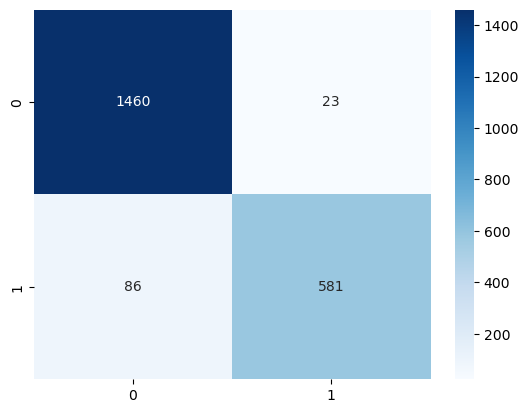

In [63]:
sns.heatmap(confusion_matrix(y_short_test, y_short_pred), annot=True, cmap='Blues', fmt='d')


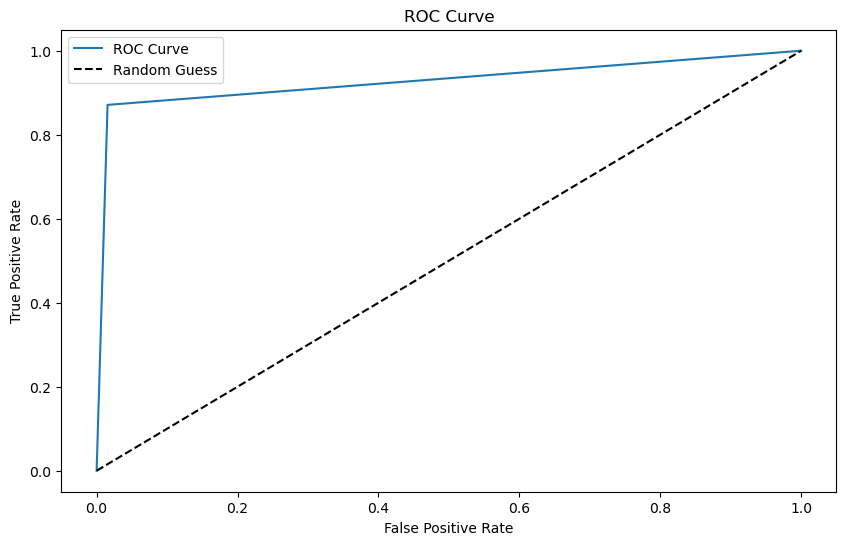

In [64]:
roc_auc_score(y_short_test, y_short_pred)

fpr, tpr, thresholds = roc_curve(y_short_test, y_short_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

### Long words

In [65]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

param_grid = {
    'forest__n_estimators': [1200, 1400, 1600],
    'forest__max_depth': [40, 50, 60],
    'forest__max_features': ['sqrt', 'log2'],
}

rnd_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=3,
    scoring='recall_macro',
    n_jobs=-1
)

rnd_search.fit(X_long_train, y_long_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('scaler',
                                                         QuantileTransformer(output_distribution='normal')),
                                                        ('pca',
                                                         PCA(n_components=np.int64(24),
                                                             random_state=42))])),
                                       ('forest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'forest__max_depth': [40, 50, 60],
                         'forest__max_features': ['sqrt', 'log2'],
                         'forest__n_estimators': [1200, 1400, 1600]},
             scoring='recall_macro')

In [66]:
model = rnd_search.best_estimator_
model.fit(X_long_train, y_long_train)

y_long_pred = model.predict(X_long_test)

print(classification_report(y_long_test, y_long_pred))
print("Accuracy: ", accuracy_score(y_long_test, y_long_pred))
print("Recall: ", recall_score(y_long_test, y_long_pred, average='macro'))
print("Precision: ", precision_score(y_long_test, y_long_pred, average='macro'))
print("F1 Score: ", f1_score(y_long_test, y_long_pred, average='macro'))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       532
           1       0.98      0.89      0.93       222

    accuracy                           0.96       754
   macro avg       0.97      0.94      0.95       754
weighted avg       0.96      0.96      0.96       754

Accuracy:  0.9628647214854111
Recall:  0.9408741448215132
Precision:  0.9699368231046932
F1 Score:  0.9539333001667059


<Axes: >

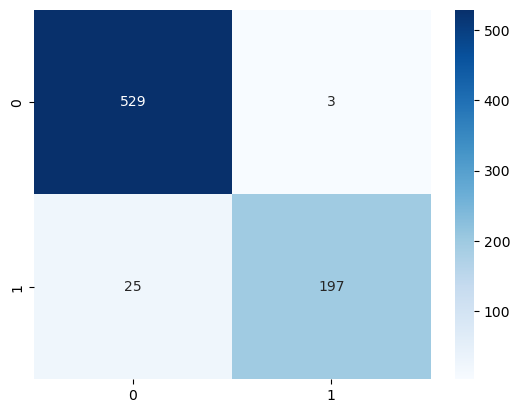

In [67]:
sns.heatmap(confusion_matrix(y_long_test, y_long_pred), annot=True, cmap='Blues', fmt='d')

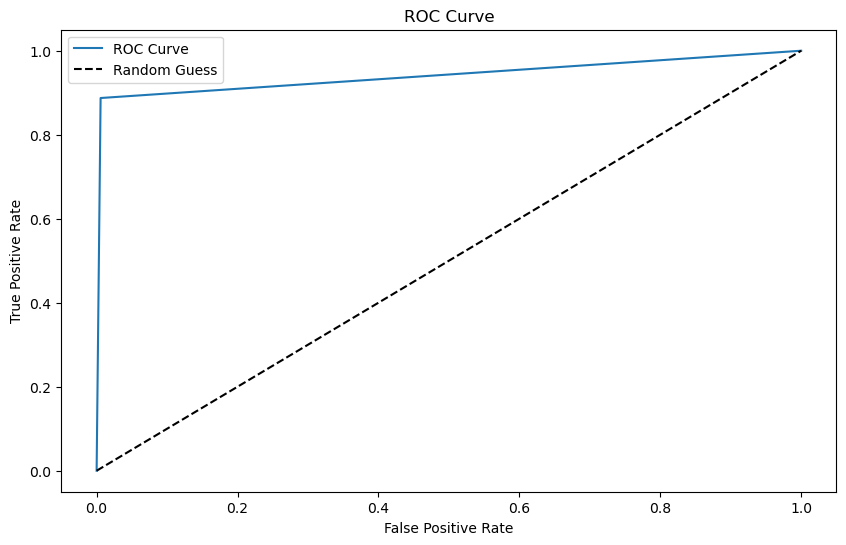

In [68]:
roc_auc_score(y_long_test, y_long_pred)

fpr, tpr, thresholds = roc_curve(y_long_test, y_long_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()


### 5XCV2

In [69]:
from sklearn.model_selection import ShuffleSplit

def run_5x2cv(X, y, random_state=42):
    splitter = ShuffleSplit(n_splits=5, test_size=0.5, random_state=random_state)
    model = RandomForestClassifier(random_state=random_state)

    all_scores = []
    all_scores_df = pd.DataFrame(columns=['Fold', 'Accuracy1', 'Accuracy2'])
    for fold, (train_idx, test_idx) in enumerate(splitter.split(X), start=1):
        # First split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score1 = accuracy_score(y_test, preds)

        # Second split (train/test reversed)
        model.fit(X_test, y_test)
        preds = model.predict(X_train)
        score2 = accuracy_score(y_train, preds)

        all_scores.append((score1, score2))
        print(f"Fold {fold}: Acc1 = {score1:.3f}, Acc2 = {score2:.3f}")
        all_scores_df.loc[len(all_scores_df)] = [fold, score1, score2]
    all_scores = np.array(all_scores)
    mean_score = np.mean(all_scores)
    var_score = np.var(all_scores)
    print(f"\nMean 5x2CV Accuracy: {mean_score:.3f}")
    print(f"\nVariance of 5x2CV Accuracy: {var_score:.3f}")
    return all_scores, all_scores_df

In [70]:
torgo_3 = long_words.copy()
y = torgo_3['label']
X = torgo_3.drop('label', axis=1)

scores,scores_df = run_5x2cv(X, y)

Fold 1: Acc1 = 0.961, Acc2 = 0.963
Fold 2: Acc1 = 0.956, Acc2 = 0.956
Fold 3: Acc1 = 0.969, Acc2 = 0.949
Fold 4: Acc1 = 0.963, Acc2 = 0.954
Fold 5: Acc1 = 0.958, Acc2 = 0.958

Mean 5x2CV Accuracy: 0.959

Variance of 5x2CV Accuracy: 0.000


In [71]:
scores_df.head()


,Fold,Accuracy1,Accuracy2
0,1.0,0.960722,0.963376
1,2.0,0.955945,0.956476
2,3.0,0.969214,0.949045
3,4.0,0.962845,0.954352
4,5.0,0.958068,0.958068


In [72]:
scores_df.drop(columns=["Fold"], inplace=True)
scores_df.describe()


,Accuracy1,Accuracy2
count,5.000000,5.000000
mean,0.961359,0.956263
std,0.005110,0.005236
min,0.955945,0.949045
25%,0.958068,0.954352
50%,0.960722,0.956476
75%,0.962845,0.958068
max,0.969214,0.963376
